In [31]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [32]:
import numpy as np
import pandas as pd

In [33]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [34]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [35]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [36]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [37]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [38]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [39]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

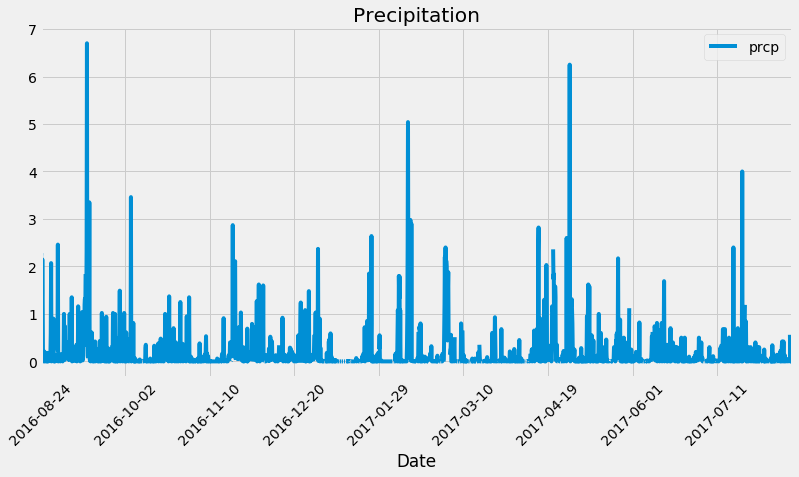

In [40]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
latest_date = (session.query(Measurement.date)
                     .order_by(Measurement.date.desc())
                     .first())

latest_date = list(np.ravel(latest_date))[0]
latest_date = dt.datetime.strptime(latest_date, '%Y-%m-%d')
latest_year = int(dt.datetime.strftime(latest_date, '%Y'))
latest_month = int(dt.datetime.strftime(latest_date, '%m'))
latest_day = int(dt.datetime.strftime(latest_date, '%d'))

# Calculate the date 1 year ago from the last data point in the database
year_ago = dt.date(latest_year, latest_month, latest_day) - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
precipitation_data = (session.query(Measurement.date, Measurement.prcp)
                  .filter(Measurement.date > year_ago)
                  .order_by(Measurement.date)
                  .all())

# Save the query results as a Pandas DataFrame and set the index to the date column
precipitation_df = pd.DataFrame(precipitation_data)
precipitation_df = precipitation_df.set_index('date')

# Sort the dataframe by date
precipitation_df = precipitation_df.sort_index(ascending=True)

# Use Pandas Plotting with Matplotlib to plot the data
precipitation_df.plot(title="Precipitation", figsize=(12,6))
plt.xlabel("Date")
plt.xticks(rotation="45")
plt.show()

In [41]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precipitation_df.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [42]:
# Design a query to show how many stations are available in this dataset?
station_count = session.query(Station).count()
print(f"Station Count: {station_count}")

Station Count: 9


In [44]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

station_counts = (session.query(Measurement.station, func.count(Measurement.station))
                        .group_by(Measurement.station)
                        .order_by(func.count(Measurement.station).desc())
                        .all())

station = station_counts[0][0]

station_name = (session.query(Station.name)
                      .filter_by(station = station))
station_name = station_name[0][0]
print("Most active stations:")

station_counts

Most active stations:


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [45]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?

lowest_temp = (session.query(Measurement.tobs)
                     .filter(Measurement.station == station)
                     .order_by(Measurement.tobs.asc())
                     .first())
lowest_temp = lowest_temp[0]

highest_temp = (session.query(Measurement.tobs)
                      .filter(Measurement.station == station)
                      .order_by(Measurement.tobs.desc())
                      .first())
highest_temp = highest_temp[0]

average_temp = (session.query(func.avg(Measurement.tobs))
                  .filter(Measurement.station == station))
average_temp = '{0:.3}'.format(average_temp[0][0])

print(f"Lowest Temperature: {lowest_temp}")
print(f"Highest Temperature: {highest_temp}")
print(f"Average Temperature: {average_temp}")

Lowest Temperature: 54.0
Highest Temperature: 85.0
Average Temperature: 71.7


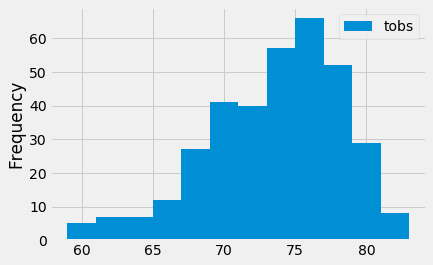

In [46]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

#Perform query temperature data
temperature = (session.query(Measurement.date, Measurement.tobs)
                   .filter(Measurement.date > year_ago)
                   .filter(Measurement.station == station)
                   .order_by(Measurement.date)
                   .all())

#Convert query object to data frame
temp_df = pd.DataFrame(temperature)
# Set index
temp_df = temp_df.set_index('date')
temp_df = temp_df.sort_index(ascending=True)

temp_df.plot(kind='hist', bins=12)
plt.show()